# 7-MonteCarlo Sampling

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/source/en/007-MonteCarloSampling.ipynb)

OpenJij implements Simulated Annealing (SA). If we keep tempereture constant, it is possible to sample spin sequences from the canonical distribution at this temperature.

$$
p(\{\sigma\}) = \frac{\exp(-\beta E(\{\sigma\}))}{Z}, \ Z = \sum_{\{\sigma\}}\exp(-\beta E(\{\sigma\}))
$$

In the following, we deal with the fully-coupled ferromagnetic ising model.

$$
E(\{\sigma\}) = \frac{J}{N} \sum_{i<j} \sigma_i \sigma_j \ (J<0)
$$

By dividing the energy by the system size $N$, we normalize the Hamiltonian to about the same size $N$. In addition, we choose $J=-1$.

In [1]:
# import libraries
import openjij as oj
import numpy as np
import matplotlib.pyplot as plt

# set sampler
sampler = oj.SASampler(num_reads=100)

# set fully_connected problem
def fully_connected(n):
    h, J = {}, {}
    for i in range(n-1):
        for j in range(i+1, n):
            J[i, j] = -1/n
    return h, J

# set h, J
h, J = fully_connected(n=500)

Let us compute the magnetization at each temperature define below.

$$
m = \frac{1}{N} \sum_i \sigma_i
$$

The closer this value is to 1, the more aligned spins are (ferromagnetic). On the other hand, the closer it is to 0, the more uneven spins are. If we perform the calculations with OpenJij at a constant temperature, we find that the magnetization value approaches 0 when the temperature is around 1.0. This is due because spins tends to fall apart as the temperature rises.

In [2]:
# set a list of temperature
temp_list = np.linspace(0.01, 2, 30)

# compute magnetization and these standard deviation
mag, mag_std = [], []
for temp in temp_list:
    beta = 1.0/temp
    schedule = [[beta, 100]]
    response = sampler.sample_ising(h, J, schedule=schedule)
    mag_list = [np.abs(np.mean(state)) for state in response.states]
    mag_std.append(np.std(mag_list))
    mag.append(np.mean(mag_list))

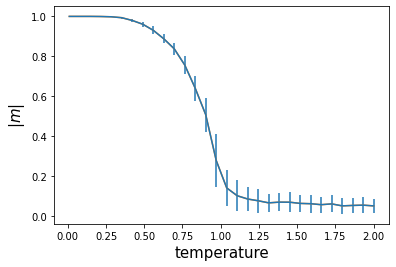

In [3]:
# visualize result
plt.errorbar(temp_list, mag, yerr=mag_std)
plt.plot(temp_list, mag)
plt.xlabel('temperature', fontsize=15)
plt.ylabel(r'$|m|$', fontsize=15)
plt.show()

This phenomenon, in which the value changes significantly from one temperature to another, is called a **phase transition**. In this model (when the system size is close to infinity), a phase transition occurs at a temperature of 1.0. It has been theoretically proven.  
However, it is often not possible to calculate the temperature at which the phase transition occurs theoretically in actual models. For this reason, MonteCarlo simulations are often used to study the properties of phase transitions numerically.

## Binder cumulant

Now, let us assume that we don't know the temperature of the phase transition, try to find the temperature of the phase transition as accurately as possible from the numerical simulations.  
Looking at the figure above, we can see the magnetization approach 0 as the temperature increases. However, it is not clear which temperature is the phase transition point. Phase transitions are theoretically phenomena that occurs in systems of infinite size, but simulations can only deal with finite size, which results in an error from the theory. This is called the **finite size effect**. Numerical analysis of system of infinite size is a seemingly impossible. However, in numerical simulation in statistical mechanics, the method of obtaining information of infinite system size from finite system size has been developed. The one of those methods it to use a quantity called **Binder cumulant**

$$U_4 \equiv \frac{1}{2}\left( 3- \frac{\langle m^4\rangle}{\langle m^2\rangle^2} \right)$$

In [5]:
# calculation of U4
def u_4(states):
    m = np.array([np.mean(state) for state in states])
    return 0.5 * (3-np.mean(m**4)/(np.mean(m**2)**2))

We defer to the statistical mechanics textbook for details. This quantity is close to 1 for ferromagnetism, where the magnetization approaches 1, and 0 for paramagnetism, where the magnetization approaches 0. Furthermore, the phase transition point is known to take a value independent of the system size. Therefore, we can perform the numerical experiments as described above for several system sizes and find that the point where the graph of $U_4$ intersects at a single point is the phase transition point.   

In [6]:
# set a list of system size
n_list = [40, 80, 120, 160]
# set a list of temperature
temp_list = np.linspace(0.5, 1.5, 30)

# set sampler
sampler = oj.SASampler(num_reads=300)

u4_list_n = []
for n in n_list:
    # make instance
    h, J = fully_connected(n)
    u4_temp = []
    for temp in temp_list:
        beta = 1.0/temp
        schedule = [[beta, 100 if temp < 0.9 else 300]]
        response = sampler.sample_ising(h, J, 
                                        schedule=schedule, reinitialize_state=False,
                                        num_reads=100 if temp < 0.9 else 1000
                                       )
        u4_temp.append(u_4(response.states))
    u4_list_n.append(u4_temp)

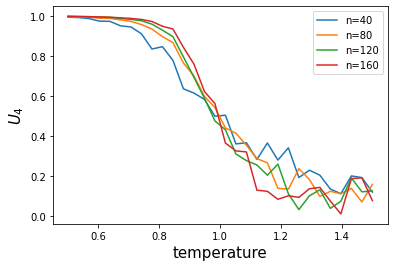

In [7]:
# visualize results
for n,u4_beta in zip(n_list,u4_list_n):
    plt.plot(temp_list, np.array(u4_beta), label='n={}'.format(n))

plt.legend()
plt.ylabel('$U_4$', fontsize=15)
plt.xlabel('temperature', fontsize=15)
plt.show()

There is variation in the data due to insufficient statistics. However, we can see that the four system sizes are intersected at a single point at a temperature near 1.0, which is roughly the phase transition point. The estimation of the phase transition point with the Binder cumulant is a popular method used at the forefront of numerical analysis.

> Of course, academic studies need to be done diligently, not only obtain sufficient statistics, but also to evaluate these errors (computation of error bars). As this calculation is limited to and overview, accurate error evaluation and more is omitted.

## Conclusion

We introduced a method of MonteCarlo sampling with annealing. We show an example of a phase transition in statistical mechanics. OpenJij can be applied in a variety of ways, depending on our ideas.